# SkimLit in TensorFlow

We're going to be replicating the deep learning model behind the 2017 paper ***PubMed 200k RCT***: a Dataset for Sequential Sentence Classification in Medical Abstracts.

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled ***Randomized Controlled Trial (RCT)*** abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

# Import the necessary utilities

In [ ]:
from utils import calculate_results, plot_loss_accuracy_curves

# Get the data
Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

The authors of the paper have made the data they used for their research available publically in the form of .txt files on GitHub.

We can copy them to our local directory using git clone `https://github.com/Franck-Dernoncourt/pubmed-rct`.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 44.73 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in the subset of PubMed_200K dataset which is PubMed_20K
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
# get the directory path
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# check all of the filenames and filepaths in the target directory
import os

filepaths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
filepaths

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess data

In [ ]:
# create a function to read the lines of a document
def get_lines(filepaths, filename):
    """
    Reads a text file and returns the lines of text as a list.

    Args:
        filepaths: a list of paths containing the target filepath to read.
        filename: name of the file that contains the data along with the extension

    Returns:
        A list of strings with one string per line from the target filename.
    """
    for path in filepaths:
        filepath = [path_split for path_split in path.split("/") if path_split == filename]
        if filepath:
            break

    with open(path, "r") as f:
        return f.readlines()

In [ ]:
train_lines = get_lines(filepaths, "train.txt")
train_lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filepaths, filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.

    Args:
        filepaths: a list of paths containing the target filepath to read.
        filename: a string of the target text file to read and extract line data
        from.

    Returns:
        A list of dictionaries each containing a line from an abstract,
        the lines label, the lines position in the abstract and the total number
        of lines in the abstract where the line is from.
    """
    input_lines = get_lines(filepaths, filename)
    abstract_lines = ""
    abstract_samples = []

    # loop through each line in target file
    for line in input_lines:
        if line.startswith("###"): # check if line is an ID line
            abstract_lines = ""
        elif line.isspace(): # check if line marks the begining of a new abstract
            abstract_lines_split = abstract_lines.splitlines() # split abstract into separate lines

            for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
                line_info = {}
                line_info["text"] = abstract_line.split("\t")[1]
                line_info["target"] = abstract_line.split("\t")[0]
                line_info["line_number"] = abstract_line_number
                line_info["total_lines"] = len(abstract_lines_split) - 1
                abstract_samples.append(line_info)
        else:
            abstract_lines += line

    return abstract_samples

In [ ]:
# get the structered data from train, test, and validation files
train_sentences = preprocess_text_with_line_numbers(filepaths, "train.txt")
test_sentences = preprocess_text_with_line_numbers(filepaths, "test.txt")
validation_sentences = preprocess_text_with_line_numbers(filepaths, "dev.txt")

len(train_sentences), len(test_sentences), len(validation_sentences), train_sentences

(180040,
 30135,
 30212,
 [{'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
   'target': 'OBJECTIVE',
   'line_number': 0,
   'total_lines': 11},
  {'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
   'target': 'METHODS',
   'line_number': 1,
   'total_lines': 11},
  {'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
   'target': 'METHODS',
   'line_number': 2,
   'total_lines': 11},
  {'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
   'target': 'METHODS',
   'line_number': 3,
   'total_lines': 11},
  {'text': 'Secondary outcome measures included

In [ ]:
# create DataFrame from dictionaries
import pandas as pd

train_df = pd.DataFrame(train_sentences)
test_df = pd.DataFrame(test_sentences)
validation_df = pd.DataFrame(validation_sentences)

train_df

,text,target,line_number,total_lines
0,To investigate the efficacy of @ weeks of dail...,OBJECTIVE,0,11
1,A total of @ patients with primary knee OA wer...,METHODS,1,11
2,Outcome measures included pain reduction and i...,METHODS,2,11
3,Pain was assessed using the visual analog pain...,METHODS,3,11
4,Secondary outcome measures included the Wester...,METHODS,4,11
...,...,...,...,...
180035,For the absolute change in percent atheroma vo...,RESULTS,7,11
180036,"For PAV , a significantly greater percentage o...",RESULTS,8,11
180037,Both strategies had acceptable side effect pro...,RESULTS,9,11
180038,"Compared with standard statin monotherapy , th...",CONCLUSIONS,10,11


In [ ]:
# check distribution of target variable for training DataFrame
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

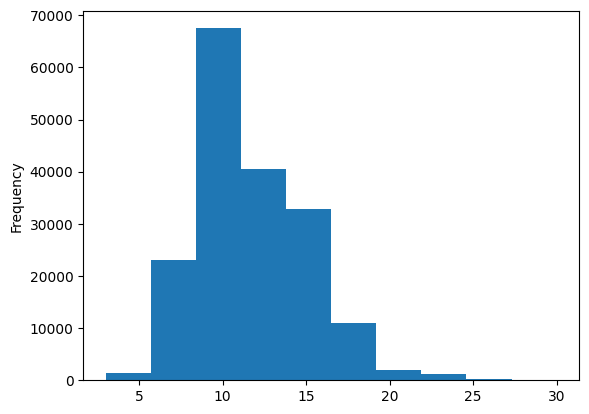

In [ ]:
# check the length of different lines for training DataFrame
train_df["total_lines"].plot.hist()

# Get list of sentences

In [ ]:
# convert abstract sentences into lists
train_data = train_df["text"].to_list()
test_data = test_df["text"].to_list()
validation_data = validation_df["text"].to_list()

train_data

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

# Make numeric labels (ML models require numeric labels)

In [ ]:
# one-hot encode the labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape((-1, 1)))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape((-1, 1)))
validation_labels_one_hot = one_hot_encoder.transform(validation_df["target"].to_numpy().reshape((-1, 1)))

In [ ]:
# check training labels array shape
train_labels_one_hot, train_labels_one_hot.shape

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 (180040, 5))

In [ ]:
# label encode the labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels = label_encoder.transform(test_df["target"].to_numpy())
validation_labels = label_encoder.transform(validation_df["target"].to_numpy())

In [ ]:
# check training labels array shape
train_labels, train_labels.shape

(array([3, 2, 2, ..., 4, 1, 1]), (180040,))

# Model 0: Getting a baseline

The baseline we'll be creating is a TF-IDF Multinomial Naive Bayes model.

To build it, we'll create a Scikit-Learn Pipeline which uses the `TfidfVectorizer` class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the `MultinomialNB` aglorithm.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using term frequency-inverse document frequency
    ("classification", MultinomialNB()), # model to use on preprocessed text data
])

# fit the pipeline on the training data
model_0.fit(train_data, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classification', MultinomialNB())])

In [ ]:
# evaluate the baseline model
baseline_score = model_0.score(validation_data, validation_labels)
print(f"Our baseline model achives an accuracy of {baseline_score*100:.2f}%")

Our baseline model achives an accuracy of 72.18%


In [ ]:
# make predictions
baseline_predictions = model_0.predict(test_data)

# get the baseline results
baseline_results = calculate_results(test_labels, baseline_predictions)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Getting the metrics of the sentences from the training dataset

In [ ]:
import numpy as np

# get the number of words in each sentence from the training dataset
sentence_lengths = [len(sentence.split()) for sentence in train_data]

# get the average length of sentences
avg_length = int(np.average(sentence_lengths))
print(f"Average number of words per sentence is {avg_length}")

Average number of words per sentence is 26


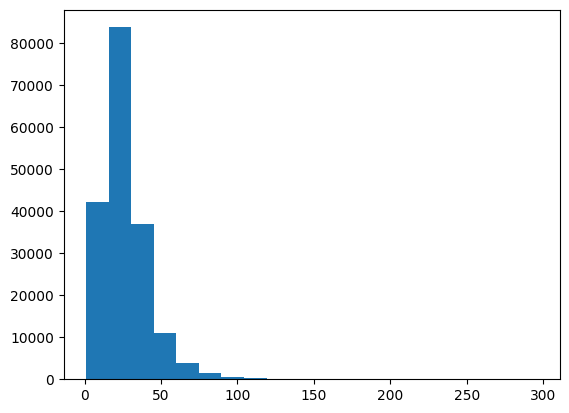

In [ ]:
# get the distribution of lengths
import matplotlib.pyplot as plt

plt.hist(sentence_lengths, bins=20);

In [ ]:
# get the length of the sentences that cover 95% of the training data
output_sequence_length = np.percentile(sentence_lengths, q=95)
output_sequence_length

55.0

In [ ]:
# maximum sentence length of the training data
np.max(sentence_lengths)

296

In [ ]:
total_unique_words = set([word for sentence in train_data for word in sentence.split()])
len(total_unique_words), total_unique_words

(83102,
 {'Haze',
  'homolog',
  'RCA',
  'druggable',
  'strata',
  'Considered',
  'PhiCal',
  'attack-relieving',
  'adhesive/cement',
  'non-trained',
  'thymic',
  'cyclase',
  'OsiriX',
  'Salt',
  'BTFC',
  'compartments',
  'opposed-phase',
  'kg.cm-@',
  'CRTs',
  'SPS',
  'out-of-home',
  'pilocarpine-induced',
  'CUPID',
  'psoriasis-related',
  'rear',
  'pre-coded',
  'POWeR',
  'Lo-AscA',
  'endothelial-dependent',
  'nine-year-old',
  'Anticoagulant',
  'Alone',
  'p@S@K',
  'DHAP',
  'intercanine',
  'supratentorial',
  'address',
  'Guides',
  'sham-acupressure',
  'lesions',
  'pharmacologically',
  'Erlotinib',
  'SCP',
  'lesion-detection',
  'Immunisation',
  'T@ng/dL',
  'ANCHOR',
  'setting',
  'Mindfulness-based',
  'Bitopertin-mediated',
  'carbide',
  'MTB',
  'eRVR',
  'Ranger',
  'Dryness',
  'discharge/reduced',
  'prolactin',
  'Quality-adjusted',
  'physician-established',
  'Cumulated',
  'ineither',
  'APAP',
  'Postplacental',
  'Prokinetic',
  'Add-on

# Creating Text Vectorization layer for words in a sentence

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# setup TextVectorization variables
max_vocabulary_length = len(total_unique_words)
max_sequence_length = avg_length

word_text_vectorizer = TextVectorization(
    max_tokens=max_vocabulary_length, # number of words in the vocabulary (if set to None it will automatically get the number of unique tokens)
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None, # create groups of n-words
    output_mode="int", # map tokens to numbers
    output_sequence_length=max_sequence_length, # the length of the sequences
    pad_to_max_tokens=False # get the length of the longest sequence and add 0s to the end of shorter sequences
)

In [ ]:
# fit the training dataset to the text vectorizer and get the vocabulary
word_text_vectorizer.adapt(train_data)
vocabulary = word_text_vectorizer.get_vocabulary()
len(vocabulary), vocabulary

(64841,
 ['',
  '[UNK]',
  'the',
  'and',
  'of',
  'in',
  'to',
  'with',
  'a',
  'were',
  'was',
  'for',
  'patients',
  'group',
  'p',
  'at',
  'or',
  'study',
  'on',
  'treatment',
  'is',
  'after',
  'by',
  'this',
  'groups',
  'as',
  'an',
  'from',
  'that',
  'randomized',
  'between',
  'not',
  'trial',
  'no',
  'compared',
  'control',
  'be',
  'significant',
  'intervention',
  'significantly',
  'n',
  'months',
  'than',
  'we',
  'vs',
  'rsb',
  'lsb',
  'clinical',
  'placebo',
  'baseline',
  'ci',
  'two',
  'during',
  'weeks',
  'both',
  'had',
  'primary',
  'mean',
  'are',
  'using',
  'participants',
  'there',
  'all',
  'time',
  'years',
  'pain',
  'therapy',
  'who',
  'mg',
  'more',
  'effect',
  'effects',
  'but',
  'risk',
  'difference',
  'outcomes',
  'total',
  'care',
  'rate',
  'efficacy',
  'received',
  'associated',
  'higher',
  'respectively',
  'days',
  'analysis',
  'outcome',
  'use',
  'one',
  'week',
  'women',
  'ma

# Creating Embedding layer for words in a sentence

In [ ]:
# creating embedding layer
word_embedding = tf.keras.layers.Embedding(input_dim=len(vocabulary),
                                           output_dim=128,
                                           input_length=max_sequence_length,
                                           mask_zero=True, # use masking to handle variable sequence lengths
                                           embeddings_initializer="uniform")

# Create datasets to be loaded and used by the GPU

The `tf.data` API provides methods which enable faster data loading.

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods `batch()` and `prefetch()`. The parameter `tf.data.AUTOTUNE` will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [ ]:
# turn our data into TensorFlow DataSets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels_one_hot))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels_one_hot))

In [ ]:
# take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Get the number of classes in the dataset

In [ ]:
# get number of classes
num_classes = len(train_df["target"].value_counts())
num_classes

5

# Model 1: Conv1D CNN

In [ ]:
# build the model using the Functional API
import tensorflow as tf

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
outputs = word_text_vectorizer(inputs)
outputs = word_embedding(outputs)
outputs = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=3, padding="same", activation="relu")(outputs)
outputs = tf.keras.layers.GlobalMaxPooling1D()(outputs)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(outputs)

model_1 = tf.keras.models.Model(inputs, outputs)

In [ ]:
# compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
# check model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 26)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 26, 128)           10637056  
                                                                 
 conv1d (Conv1D)             (None, 9, 64)             24640     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# fit the model
model_1_history = model_1.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.2*len(train_dataset)),
                              validation_data=validation_dataset,
                              validation_steps=int(0.2*len(validation_dataset)))

Epoch 1/3
1125/1125 [==============================] - 41s 32ms/step - loss: 0.7593 - accuracy: 0.7154 - val_loss: 0.5812 - val_accuracy: 0.7839
Epoch 2/3
1125/1125 [==============================] - 10s 9ms/step - loss: 0.5773 - accuracy: 0.7874 - val_loss: 0.5442 - val_accuracy: 0.7958
Epoch 3/3
1125/1125 [==============================] - 10s 9ms/step - loss: 0.5689 - accuracy: 0.7910 - val_loss: 0.5252 - val_accuracy: 0.8024


**Note:** Training and validation have been done on ***20% of the training and validation dataset, respectively***.

In [ ]:
# evaluate the model
model_1_score = model_1.evaluate(validation_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5324 - accuracy: 0.8046


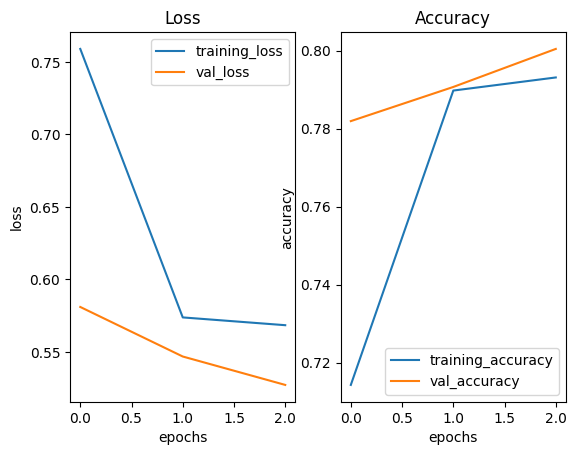

In [ ]:
# check model loss and accuracy
plot_loss_accuracy_curves(model_1_history)

In [ ]:
# make predictions
model_1_predictions = model_1.predict(test_dataset)

# get the model results
model_1_results = calculate_results(test_labels, tf.argmax(model_1_predictions, axis=1))
model_1_results

942/942 [==============================] - 3s 3ms/step


{'accuracy': 79.95022399203584,
 'precision': 0.7982582307820563,
 'recall': 0.7995022399203584,
 'f1': 0.7963118852926161}

In [ ]:
# check if our Keras model_1 is better than our scikit-learn baseline model_0
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

# Model 2: TensorFlow Hub Pretrained Universal Sentence Encoder

In [ ]:
import tensorflow_hub as hub
sentence_embedding = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
sentence_embedding.trainable_variables

ListWrapper([<tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32, numpy=
array([[-0.44756386, -0.7523224 , -2.8879747 , ..., -4.275423  ,
        -0.50384414, -2.5144944 ],
       [ 0.19551526,  0.18014883,  0.24043915, ..., -0.2736297 ,
         0.10923431,  0.20877579],
       [-0.14282258,  0.0094786 , -0.02283357, ...,  0.05814617,
         0.07281963,  0.1362249 ],
       ...,
       [ 0.25273287, -0.06458262, -0.0383645 , ..., -0.05067257,
        -0.04441866,  0.03095888],
       [-0.01667571,  0.05448845,  0.009569  , ...,  0.00490127,
        -0.04033831,  0.24144703],
       [ 0.03673933, -0.1211024 , -0.03498175, ...,  0.07811887,
        -0.00703663,  0.22115262]], dtype=float32)>, <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32, numpy=
array([[ 3.1123035e+00,  1.9035040e+00, -2.4504054e+00, ...,
        -3.6000068e+00,  1.6262866e+00,  3.8986406e+00],
       [ 3.1896163e-02,  4.0815596e-02,  3.2115210e-02, ...,
        -8.2207076e-

In [ ]:
# create a Keras layer using the Universal Sentence Encoder pretrained layer from TF Hub
sentence_encoder_layer = hub.KerasLayer(handle="https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        dtype=tf.string)

In [ ]:
# create a model using the Sequential API
model_2 = tf.keras.models.Sequential([
    sentence_encoder_layer, # tokenize text and create embedding for each sequence (with variable input length)
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [ ]:
# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
# check model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256830981 (979.73 MB)
Trainable params: 33157 (129.52 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# fit the model
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.2*len(train_dataset)),
                              validation_data=validation_dataset,
                              validation_steps=int(0.2*len(validation_dataset)))

Epoch 1/3
1125/1125 [==============================] - 17s 14ms/step - loss: 0.8639 - accuracy: 0.6662 - val_loss: 0.7686 - val_accuracy: 0.7006
Epoch 2/3
1125/1125 [==============================] - 15s 13ms/step - loss: 0.7543 - accuracy: 0.7106 - val_loss: 0.7409 - val_accuracy: 0.7149
Epoch 3/3
1125/1125 [==============================] - 15s 13ms/step - loss: 0.7487 - accuracy: 0.7137 - val_loss: 0.7104 - val_accuracy: 0.7265


In [ ]:
# evaluate the model
model_2_score = model_2.evaluate(validation_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7130 - accuracy: 0.7268


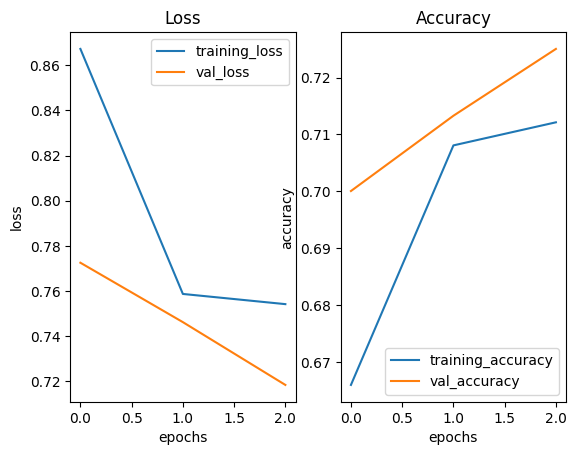

In [ ]:
# check model loss and accuracy
plot_loss_accuracy_curves(model_2_history)

In [ ]:
# make predictions
model_2_predictions = model_2.predict(test_dataset)

# get the model results
model_2_results = calculate_results(test_labels, tf.argmax(model_2_predictions, axis=1))
model_2_results

942/942 [==============================] - 10s 10ms/step


{'accuracy': 72.00929152148665,
 'precision': 0.7148002106420681,
 'recall': 0.7200929152148664,
 'f1': 0.7163851093879617}

In [ ]:
# check if our Keras model_2 is better than our scikit-learn baseline model_0
import numpy as np
np.array(list(model_2_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

# Getting the metrics of the ***sentences split into characters*** from the training dataset

In [ ]:
# get the number of words in each sentence from the training dataset
char_sentence_lengths = [len(list(sentence)) for sentence in train_data]

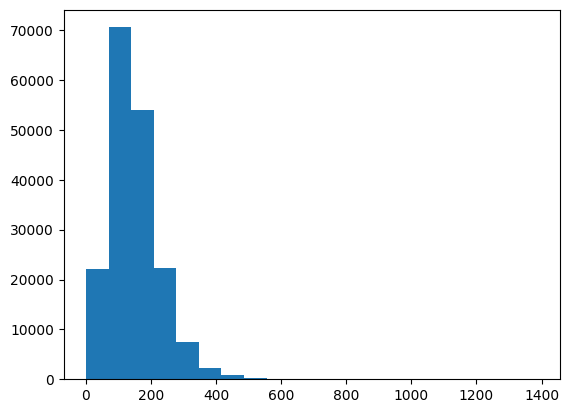

In [ ]:
# get the distribution of lengths
plt.hist(char_sentence_lengths, bins=20);

In [ ]:
# get the length of the sentences that cover 95% of the training data
output_char_sequence_length = np.percentile(char_sentence_lengths, q=95)
output_char_sequence_length

290.0

In [ ]:
# maximum sentence length of the training data
np.max(char_sentence_lengths)

1386

# Creating Text Vectorization layer for characters in a sentence

In [ ]:
# make function to split sentences into characters
def split_sentence(sentence):
    return ' '.join(list(sentence))

**Note:** The characters are separated by the **space character** (just like the words in a sentence) so that the **text vectorization layer** works properly.

In [ ]:
# split sequence-level data splits into character-level data splits
train_data_characters = [split_sentence(sentence) for sentence in train_data]
test_data_characters = [split_sentence(sentence) for sentence in test_data]
validation_data_characters = [split_sentence(sentence) for sentence in validation_data]

In [ ]:
import numpy as np

char_lengths = [len(sentence) for sentence in train_data]
char_avg = int(np.average(char_lengths))
print(f"Average number of characters per sentence is {char_avg}")

Average number of characters per sentence is 149


In [ ]:
# get all keyboard characters
import string

keyboard = string.ascii_lowercase + string.digits + string.punctuation
keyboard

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# setup TextVectorization variables
max_char_length = len(keyboard) + 2 # add 2 for space and OOV (out of vocabulary) tokens (OOV = '[UNK]')
max_char_sequence_length = int(output_char_sequence_length)

char_text_vectorizer = TextVectorization(
    max_tokens=max_char_length, # number of characters in the vocabulary (if set to None it will automatically get the number of unique tokens)
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None, # create groups of n-characters
    output_mode="int", # map tokens to numbers
    output_sequence_length=max_char_sequence_length, # the length of the sequences
    pad_to_max_tokens=False # get the length of the longest sequence and add 0s to the end of shorter sequences
)

In [ ]:
# fit the training dataset to the text vectorizer and get the vocabulary
char_text_vectorizer.adapt(train_data_characters)
char_vocabulary = char_text_vectorizer.get_vocabulary()
len(char_vocabulary), char_vocabulary

(28,
 ['',
  '[UNK]',
  'e',
  't',
  'i',
  'a',
  'n',
  'o',
  'r',
  's',
  'd',
  'c',
  'l',
  'h',
  'p',
  'm',
  'u',
  'f',
  'g',
  'y',
  'w',
  'v',
  'b',
  'k',
  'x',
  'z',
  'q',
  'j'])

# Creating Embedding layer for characters in a sentence

In [ ]:
# creating embedding layer
char_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocabulary),
                                                output_dim=25,
                                                input_length=max_char_sequence_length,
                                                mask_zero=True, # use masking to handle variable sequence lengths
                                                embeddings_initializer="uniform")

In [ ]:
# turn our data into TensorFlow DataSets
train_dataset_characters = tf.data.Dataset.from_tensor_slices((train_data_characters, train_labels_one_hot))
test_dataset_characters = tf.data.Dataset.from_tensor_slices((test_data_characters, test_labels_one_hot))
validation_dataset_characters = tf.data.Dataset.from_tensor_slices((validation_data_characters, validation_labels_one_hot))

In [ ]:
# take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset_characters = train_dataset_characters.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_characters = test_dataset_characters.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_characters = validation_dataset_characters.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model 3: Conv1D with character embeddings

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters where as a **token embedding** is created on sequences split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the `TextVectorization` class and then passing those vectorized sequences through an `Embedding` layer.

In [ ]:
# build the model using the Functional API
import tensorflow as tf

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
outputs = char_text_vectorizer(inputs)
outputs = char_embedding(outputs)
outputs = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=3, padding="same", activation="relu")(outputs)
outputs = tf.keras.layers.GlobalMaxPooling1D()(outputs)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(outputs)

model_3 = tf.keras.models.Model(inputs, outputs)

In [ ]:
# compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
# check model summary
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 290)               0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 97, 64)            4864      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

In [ ]:
# fit the model
model_3_history = model_3.fit(train_dataset_characters,
                              epochs=3,
                              steps_per_epoch=int(0.2*len(train_dataset_characters)),
                              validation_data=validation_dataset_characters,
                              validation_steps=int(0.2*len(validation_dataset_characters)))

Epoch 1/3
1125/1125 [==============================] - 8s 6ms/step - loss: 1.3136 - accuracy: 0.4532 - val_loss: 1.1901 - val_accuracy: 0.5141
Epoch 2/3
1125/1125 [==============================] - 7s 6ms/step - loss: 1.1382 - accuracy: 0.5384 - val_loss: 1.1045 - val_accuracy: 0.5496
Epoch 3/3
1125/1125 [==============================] - 6s 5ms/step - loss: 1.0906 - accuracy: 0.5590 - val_loss: 1.0648 - val_accuracy: 0.5694


In [ ]:
# evaluate the model
model_3_score = model_3.evaluate(validation_dataset_characters)

945/945 [==============================] - 4s 4ms/step - loss: 1.0618 - accuracy: 0.5743


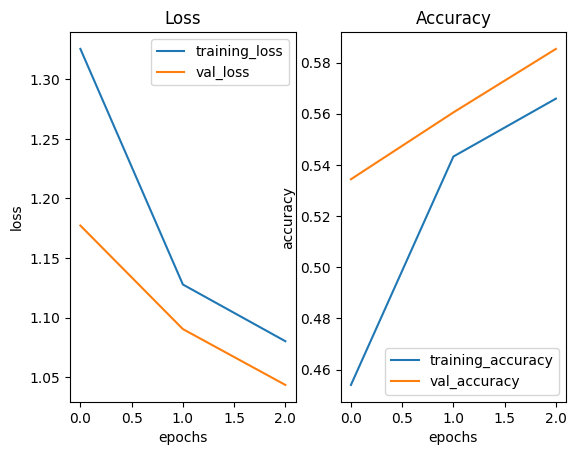

In [ ]:
# check model loss and accuracy
plot_loss_accuracy_curves(model_3_history)

In [ ]:
# make predictions
model_3_predictions = model_3.predict(test_dataset_characters)

# get the model results
model_3_results = calculate_results(test_labels, tf.argmax(model_3_predictions, axis=1))
model_3_results

942/942 [==============================] - 3s 3ms/step


{'accuracy': 57.3950555832089,
 'precision': 0.5624924304151958,
 'recall': 0.573950555832089,
 'f1': 0.5548865708536387}

In [ ]:
# check if our Keras model_3 is better than our scikit-learn baseline model_0
import numpy as np
np.array(list(model_3_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

# Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

To build a model similar to the one in Figure 1 of ***Neural Networks for Joint Sentence Classification in Medical Paper Abstracts***, we will create the **hybrid token embedding layer**.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

To start replicating the model in Figure 1, we're going to go through the following steps:

1. Create a token-level model
2. Create a character-level model (with a slight modification to reflect the paper)
3. Combine (using `layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Create token embeddings model
inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="word_input")
outputs = sentence_encoder_layer(inputs)
outputs = tf.keras.layers.Dense(units=128, activation="relu")(outputs)
word_embedding_model = tf.keras.models.Model(inputs, outputs)

In [ ]:
# 2. Create character embeddings model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
outputs = char_text_vectorizer(inputs)
outputs = char_embedding(outputs)
outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=24,
                                                             activation="tanh",
                                                             recurrent_activation="sigmoid"))(outputs)
char_embedding_model = tf.keras.models.Model(inputs, outputs)

In [ ]:
# 3. Concatenate word and character emdeddings (create hybrid token embedding)
word_char_concatenate = tf.keras.layers.Concatenate(axis=1, name="word_char_concatenated")([word_embedding_model.outputs[0],
                                                                                            char_embedding_model.outputs[0]])

In [ ]:
# 4. Create output layers
outputs = tf.keras.layers.Dropout(rate=0.5)(word_char_concatenate)
outputs = tf.keras.layers.Dense(units=128, activation="relu")(outputs)
outputs = tf.keras.layers.Dropout(rate=0.5)(outputs)
outputs = tf.keras.layers.Dense(units=num_classes, activation="softmax")(outputs)

In [ ]:
# 5. Create the model
model_4 = tf.keras.models.Model(inputs=[word_embedding_model.inputs[0],
                                        char_embedding_model.inputs[0]], outputs=outputs)

In [ ]:
# compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
# check model summary
model_4.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 word_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 keras_layer (KerasLayer)    (None, 512)                  2567978   ['word_input[0][0]']    

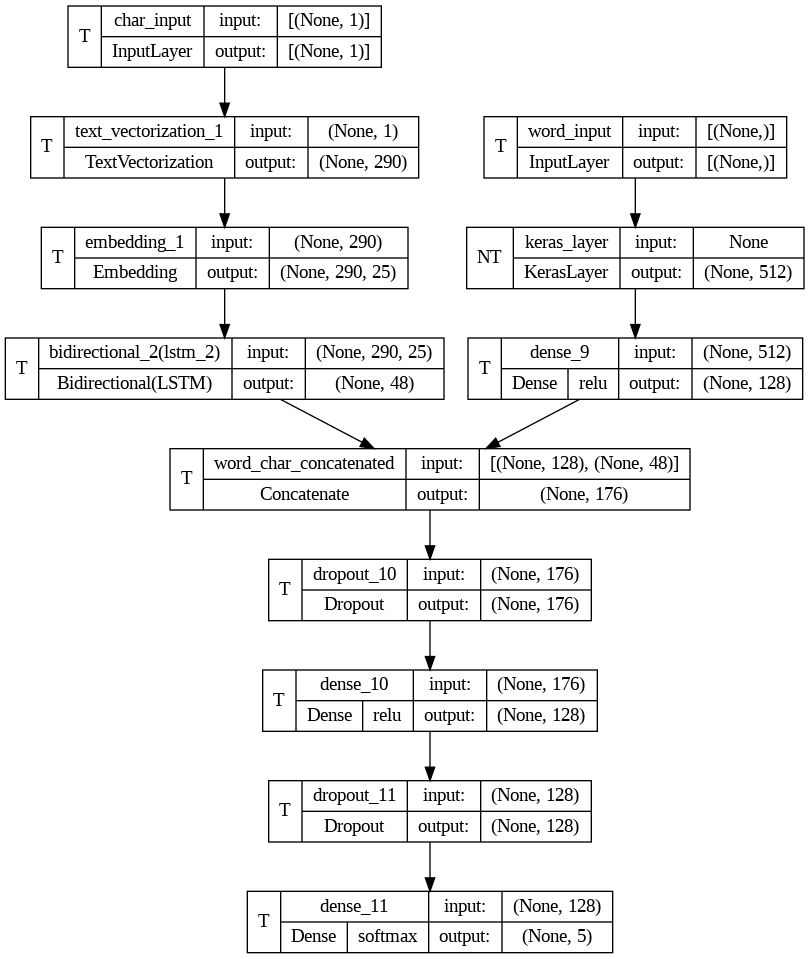

In [ ]:
# plot hybrid word and character model
from keras.utils import plot_model

plot_model(model=model_4,
           show_shapes=True,
           show_layer_activations=True,
           show_trainable=True)

# Combining word and character data into a `tf.data.Dataset`

In [ ]:
# turn our data into TensorFlow DataSets
train_dataset_features = tf.data.Dataset.from_tensor_slices((train_data, train_data_characters))
train_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset_concatenate = tf.data.Dataset.zip((train_dataset_features, train_dataset_labels))

test_dataset_features = tf.data.Dataset.from_tensor_slices((test_data, test_data_characters))
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset_concatenate = tf.data.Dataset.zip((test_dataset_features, test_dataset_labels))

validation_dataset_features = tf.data.Dataset.from_tensor_slices((validation_data, validation_data_characters))
validation_dataset_labels = tf.data.Dataset.from_tensor_slices(validation_labels_one_hot)
validation_dataset_concatenate = tf.data.Dataset.zip((validation_dataset_features, validation_dataset_labels))

In [ ]:
# take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset_concatenate = train_dataset_concatenate.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_concatenate = test_dataset_concatenate.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_concatenate = validation_dataset_concatenate.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# fit the model
model_4_history = model_4.fit(train_dataset_concatenate,
                              epochs=3,
                              steps_per_epoch=int(0.2*len(train_dataset_concatenate)),
                              validation_data=validation_dataset_concatenate,
                              validation_steps=int(0.2*len(validation_dataset_concatenate)))

Epoch 1/3
1125/1125 [==============================] - 75s 53ms/step - loss: 0.8984 - accuracy: 0.6457 - val_loss: 0.7259 - val_accuracy: 0.7265
Epoch 2/3
1125/1125 [==============================] - 52s 46ms/step - loss: 0.7676 - accuracy: 0.7091 - val_loss: 0.6796 - val_accuracy: 0.7462
Epoch 3/3
1125/1125 [==============================] - 49s 44ms/step - loss: 0.7512 - accuracy: 0.7167 - val_loss: 0.6548 - val_accuracy: 0.7533


In [ ]:
# evaluate the model
model_4_score = model_4.evaluate(validation_dataset_concatenate)

945/945 [==============================] - 18s 20ms/step - loss: 0.6590 - accuracy: 0.7476


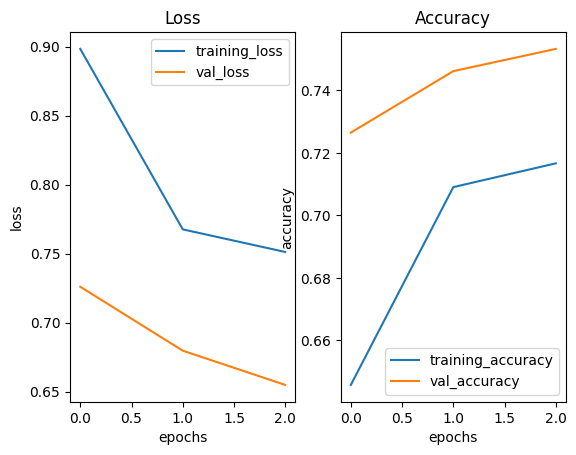

In [ ]:
# check model loss and accuracy
plot_loss_accuracy_curves(model_4_history)

In [ ]:
# make predictions
model_4_predictions = model_4.predict(test_dataset_concatenate)

# get the model results
model_4_results = calculate_results(test_labels, tf.argmax(model_4_predictions, axis=1))
model_4_results

942/942 [==============================] - 22s 20ms/step


{'accuracy': 74.23593827775012,
 'precision': 0.7369250365182802,
 'recall': 0.7423593827775012,
 'f1': 0.7372002134111035}

In [ ]:
# check if our Keras model_4 is better than our scikit-learn baseline model_0
import numpy as np
np.array(list(model_4_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

What if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called ***feature engineering***.

We can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

The **"line_number"** and **"total_lines"** columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

***We can use these features because they will be available at test time.***

Since abstracts typically have a sequential order about them (for example, background, objective, methods, results, conclusion), it makes sense to add the line number of where a particular sentence occurs to our model. The beautiful thing is, these features will be available at test time (we can just count the number of sentences in an abstract and the number of each one).

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

# Create positional embeddings

In [ ]:
# check line_number column values from DataFrame
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

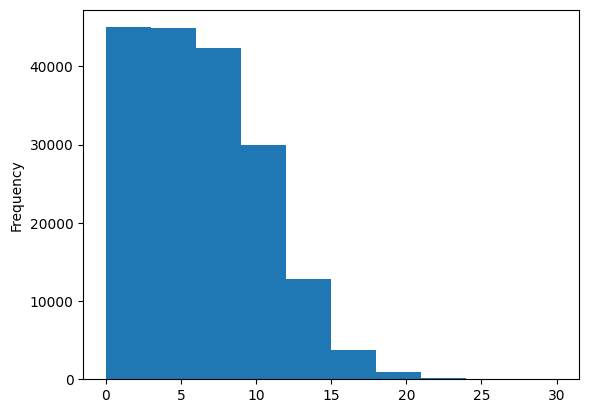

In [ ]:
# check the distribution of line_number column values
train_df["line_number"].plot(kind="hist")

In [ ]:
# check total_lines column values from DataFrame
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

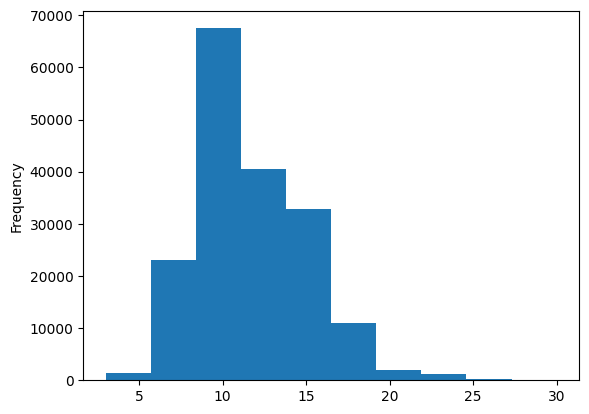

In [ ]:
# check the distribution of total_lines column values
train_df["total_lines"].plot(kind="hist")

In [ ]:
# one-hot encode both column values
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
validation_line_number_one_hot = tf.one_hot(validation_df["line_number"].to_numpy(), depth=15)

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=15)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=15)
validation_total_lines_one_hot = tf.one_hot(validation_df["total_lines"].to_numpy(), depth=15)

# Building a tribrid embedding model

The model we're going to build incorporates token embeddings, character embeddings and positional embeddings.

We're going to go through the following steps:

1. Create a token-level model
2. Create a character-level model (with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using `layers.Concatenate`) the outputs of 1 and 2 into a token-character-hybrid embedding and **add a Dense and a Dropout layer** as the output
6. Combine (using `layers.Concatenate`) the outputs of 3 and 4 into a positional embedding
7. Combine (using `layers.Concatenate`) the outputs of 5 and 6 into a token-character-positional tribrid embedding
8. Create an output layer to accept the tribrid embedding and output predicted label probabilities
9. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.models.Model`

In [ ]:
# 1. Create token embeddings model
inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="word_input")
outputs = sentence_encoder_layer(inputs)
outputs = tf.keras.layers.Dense(units=128, activation="relu")(outputs)
word_embedding_model = tf.keras.models.Model(inputs, outputs)

In [ ]:
# 2. Create character embeddings model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
outputs = char_text_vectorizer(inputs)
outputs = char_embedding(outputs)
outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=24,
                                                             activation="tanh",
                                                             recurrent_activation="sigmoid"))(outputs)
char_embedding_model = tf.keras.models.Model(inputs, outputs)

In [ ]:
# 3. Create "line_number" model
inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
outputs = tf.keras.layers.Dense(units=64, activation="relu")(inputs)
outputs = tf.keras.layers.Dropout(rate=0.2)(outputs)
outputs = tf.keras.layers.Dense(units=64, activation="relu")(outputs)
line_number_model = tf.keras.models.Model(inputs, outputs)

In [ ]:
# 4. Create "total_lines" model
inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name="total_lines_input")
outputs = tf.keras.layers.Dense(units=32, activation="relu")(inputs)
outputs = tf.keras.layers.Dropout(rate=0.2)(outputs)
outputs = tf.keras.layers.Dense(units=32, activation="relu")(outputs)
total_lines_model = tf.keras.models.Model(inputs, outputs)

In [ ]:
# 5. Concatenate word and character emdeddings (create hybrid token embedding) and add Dense and Dropout layers
word_char_concatenate = tf.keras.layers.Concatenate(axis=1, name="word_char_concatenated")([word_embedding_model.outputs[0],
                                                                                            char_embedding_model.outputs[0]])
combined_output = tf.keras.layers.Dense(units=256, activation="relu")(word_char_concatenate)
combined_output = tf.keras.layers.Dropout(rate=0.5)(combined_output)

In [ ]:
# 6. Concatenate "line_number" model and "total_lines" model
feature_engineering_concatenate = tf.keras.layers.Concatenate(axis=1, name="feature_engineering_concatenated")([line_number_model.outputs[0],
                                                                                                                total_lines_model.outputs[0]])

In [ ]:
# 7. Concatenate hybrid token embedding and feature engineering models
tribrid_embedding_concatenate = tf.keras.layers.Concatenate(axis=1, name="tribrid_embedding_concatenated")([combined_output,
                                                                                                            feature_engineering_concatenate])

In [ ]:
# 8. Create final output layer
final_output = tf.keras.layers.Dense(units=num_classes, activation="softmax")(tribrid_embedding_concatenate)

In [ ]:
# 9. Create the model
model_5 = tf.keras.models.Model(inputs=[word_embedding_model.inputs[0],
                                        char_embedding_model.inputs[0],
                                        line_number_model.inputs[0],
                                        total_lines_model.inputs[0]], outputs=final_output)

In [ ]:
# compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps prevent overfitting
                optimizer="adam",
                metrics=["accuracy"])

# What is label smoothing?

The parameter `label_smoothing` from `tf.keras.losses.CategoricalCrossentropy` loss function helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

What label smoothing does is ***it assigns some of the value form the highest predicted probability to other classes***, in turn, improving generalization.

In [ ]:
# check model summary
model_5.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 word_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 keras_layer (KerasLayer)    (None, 512)                  2567978   ['word_input[0][0]']   

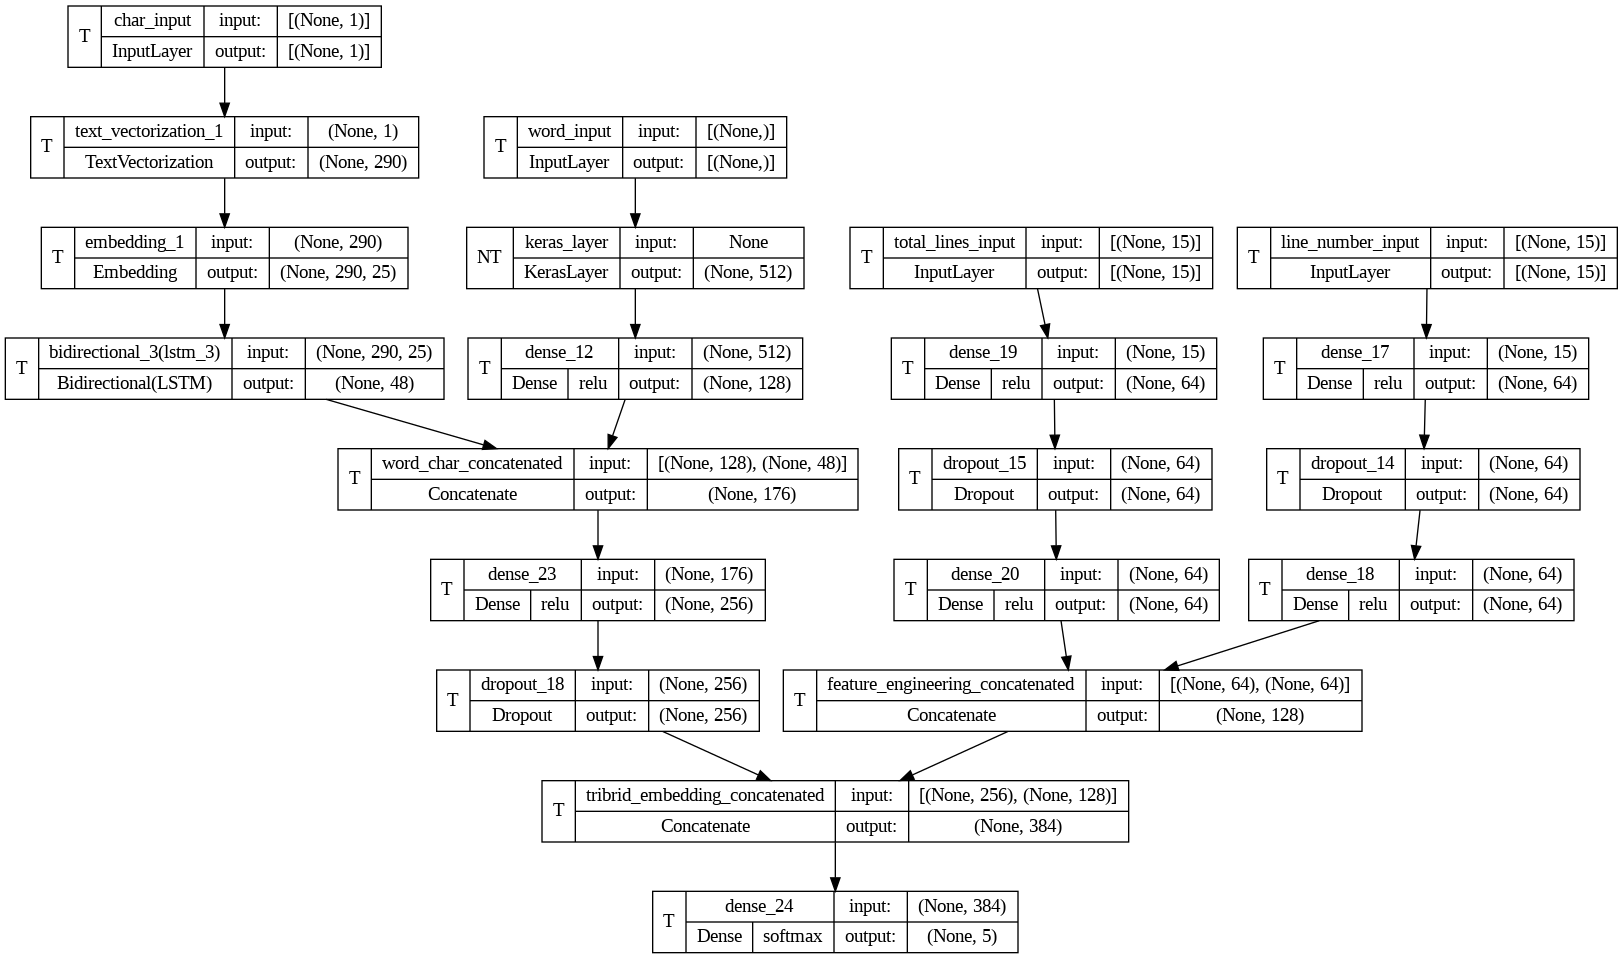

In [ ]:
# plot hybrid word and character model
from keras.utils import plot_model

plot_model(model=model_5,
           show_shapes=True,
           show_layer_activations=True,
           show_trainable=True)

# Create tribrid embedding datasets

In [ ]:
# turn train data into TensorFlow DataSet
train_dataset_features = tf.data.Dataset.from_tensor_slices((train_data,
                                                             train_data_characters,
                                                             train_line_number_one_hot,
                                                             train_total_lines_one_hot))
train_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset_concatenate = tf.data.Dataset.zip((train_dataset_features, train_dataset_labels))

# turn test data into TensorFlow DataSet
test_dataset_features = tf.data.Dataset.from_tensor_slices((test_data,
                                                            test_data_characters,
                                                            test_line_number_one_hot,
                                                            test_total_lines_one_hot))
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset_concatenate = tf.data.Dataset.zip((test_dataset_features, test_dataset_labels))

# turn validation data into TensorFlow DataSet
validation_dataset_features = tf.data.Dataset.from_tensor_slices((validation_data,
                                                                  validation_data_characters,
                                                                  validation_line_number_one_hot,
                                                                  validation_total_lines_one_hot))
validation_dataset_labels = tf.data.Dataset.from_tensor_slices(validation_labels_one_hot)
validation_dataset_concatenate = tf.data.Dataset.zip((validation_dataset_features, validation_dataset_labels))

In [ ]:
# take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset_concatenate = train_dataset_concatenate.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_concatenate = test_dataset_concatenate.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_concatenate = validation_dataset_concatenate.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Fitting the model ***on 20% of the training data*** for faster training times and results

In [ ]:
# fit the model
model_5_history = model_5.fit(train_dataset_concatenate,
                              epochs=3,
                              steps_per_epoch=int(0.2*len(train_dataset_concatenate)),
                              validation_data=validation_dataset_concatenate,
                              validation_steps=int(0.2*len(validation_dataset_concatenate)))

Epoch 1/3
1125/1125 [==============================] - 80s 53ms/step - loss: 1.0154 - accuracy: 0.7801 - val_loss: 0.9369 - val_accuracy: 0.8318
Epoch 2/3
1125/1125 [==============================] - 56s 49ms/step - loss: 0.9464 - accuracy: 0.8293 - val_loss: 0.9259 - val_accuracy: 0.8353
Epoch 3/3
1125/1125 [==============================] - 54s 48ms/step - loss: 0.9416 - accuracy: 0.8313 - val_loss: 0.9104 - val_accuracy: 0.8467


In [ ]:
# evaluate the model
model_5_score = model_5.evaluate(validation_dataset_concatenate)

945/945 [==============================] - 19s 20ms/step - loss: 0.9147 - accuracy: 0.8450


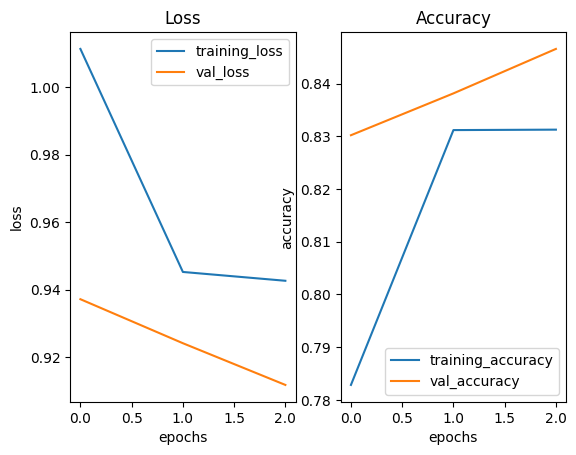

In [ ]:
# check model loss and accuracy
plot_loss_accuracy_curves(model_5_history)

In [ ]:
# make predictions
model_5_predictions = model_5.predict(test_dataset_concatenate)

# get the model results
model_5_results = calculate_results(test_labels, tf.argmax(model_5_predictions, axis=1))
model_5_results

942/942 [==============================] - 22s 21ms/step


{'accuracy': 83.99203583872573,
 'precision': 0.8393240760999785,
 'recall': 0.8399203583872573,
 'f1': 0.8370761799764114}

In [ ]:
# check if our Keras model_5 is better than our scikit-learn baseline model_0
import numpy as np
np.array(list(model_5_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

# Compare model results

In [ ]:
# combine model results into a DataFrame
import pandas as pd

all_results = pd.DataFrame({"baseline": baseline_results,
                            "custom_token_embed_conv1d": model_1_results,
                            "pretrained_token_embed": model_2_results,
                            "custom_char_embed_conv1d": model_3_results,
                            "hybrid_char_token_embed": model_4_results,
                            "tribrid_embed": model_5_results})
all_results

,baseline,custom_token_embed_conv1d,pretrained_token_embed,custom_char_embed_conv1d,hybrid_char_token_embed,tribrid_embed
accuracy,72.183238,79.950224,72.009292,57.395056,74.235938,84.148001
precision,0.718647,0.798258,0.714800,0.562492,0.736925,0.841399
recall,0.721832,0.799502,0.720093,0.573951,0.742359,0.841480
f1,0.698925,0.796312,0.716385,0.554887,0.737200,0.838735


In [ ]:
# reduce the accuracy to same scale as other metrics
all_results.iloc[0] = all_results.iloc[0]/100
all_results

,baseline,custom_token_embed_conv1d,pretrained_token_embed,custom_char_embed_conv1d,hybrid_char_token_embed,tribrid_embed
accuracy,0.721832,0.799502,0.720093,0.573951,0.742359,0.841480
precision,0.718647,0.798258,0.714800,0.562492,0.736925,0.841399
recall,0.721832,0.799502,0.720093,0.573951,0.742359,0.841480
f1,0.698925,0.796312,0.716385,0.554887,0.737200,0.838735


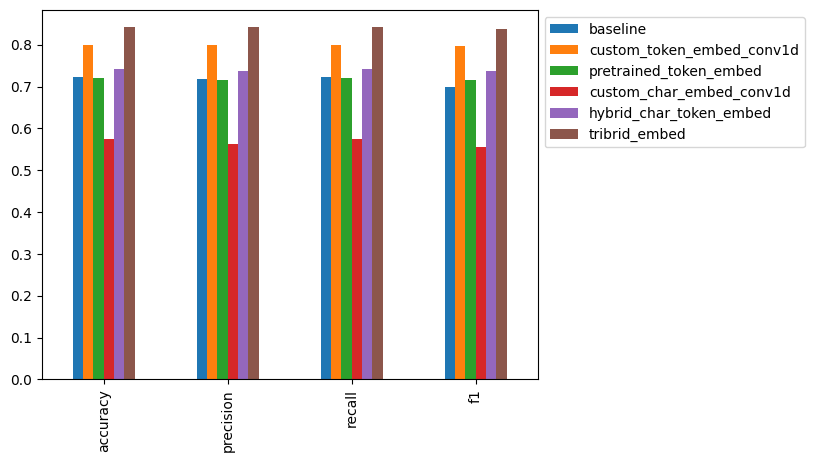

In [ ]:
# plot all results
all_results.plot(kind="bar").legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

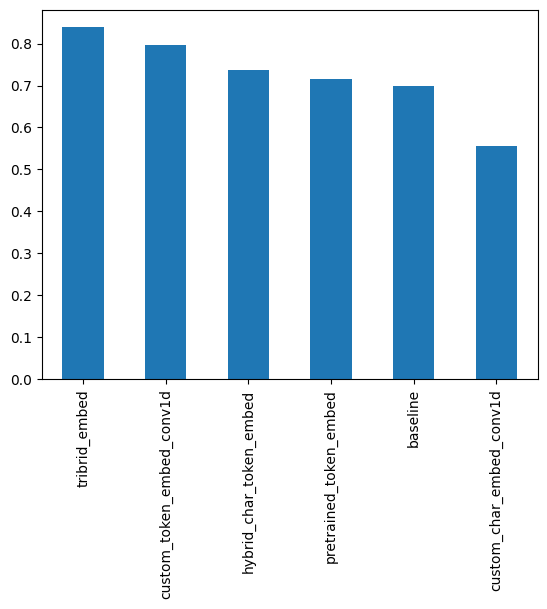

In [ ]:
# sort model results by f1-score
all_results.iloc[-1].sort_values(ascending=False).plot(kind="bar")

# Make example predictions

We're going to find an RCT abstract from PubMed, preprocess the text so it works with our model, then pass each sequence in the abstract through our model to see what label it predicts.

For an appropriate sample, we'll need to search PubMed for RCT's (randomized controlled trials) without abstracts which have been split up (on exploring PubMed you'll notice many of the abstracts are already preformatted into separate sections, this helps dramatically with readability).

For each abstract that hasn't been formatted in the same structure as the data our models have been trained on, we'll need to:

1. Split the abstract into sentences (lines).
2. Split the abstract into characters.
3. Find the number of each line.
4. Find the total number of lines.





In [ ]:
import json
# download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
    example_abstracts = json.load(f)

example_abstracts

--2023-10-22 11:45:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-10-22 11:45:05 (92.0 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

**Note:** An advanced option for splitting an abstract into sentences would be to leverage spaCy's (a very powerful NLP library) `sentencizer` class. Which is an easy to use sentence splitter based on spaCy's English language model.

In [ ]:
# check example abstracts
import pandas as pd

abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# create sentencizer
from spacy.lang.en import English

nlp = English() # setup English sentence parser
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# get total number of lines
total_lines_in_sample = len(abstract_lines)

# go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []

for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)

sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
import tensorflow as tf

# get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

# one-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]

# one-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=15)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# split abstract lines into characters
abstract_chars = [split_sentence(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# make predictions on sample abstract features
%%time
test_abstract_pred_probs = model_5.predict(x=(tf.constant(abstract_lines),
                                              tf.constant(abstract_chars),
                                              test_abstract_line_numbers_one_hot,
                                              test_abstract_total_lines_one_hot))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step
CPU times: user 2.85 s, sys: 65.3 ms, total: 2.92 s
Wall time: 2.86 s


array([[0.37302354, 0.10307984, 0.03421558, 0.42268065, 0.06700037],
       [0.06874797, 0.03080442, 0.7826566 , 0.07867769, 0.03911333],
       [0.07830858, 0.03610466, 0.71877456, 0.09042009, 0.0763921 ],
       [0.10957266, 0.17087117, 0.4716451 , 0.06902125, 0.17888978],
       [0.05505769, 0.0972193 , 0.3499744 , 0.04793271, 0.4498158 ],
       [0.02796259, 0.07939614, 0.6591945 , 0.03126832, 0.20217845],
       [0.0356583 , 0.25632417, 0.06809496, 0.02671943, 0.61320317],
       [0.01123937, 0.06760602, 0.05802011, 0.01794529, 0.8451892 ]],
      dtype=float32)

In [ ]:
# turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [ ]:
# turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# sisualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
